# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
#!pip3 install torch

In [2]:
#!pip3 install torchvision

In [3]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os
from tqdm.notebook import tqdm

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.1


# Preparing Training and Test Sets

In [4]:
class_names = ['normal', 'viral', 'covid']
root_dir    = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test')) # # create empty test set folder

    for i, d in enumerate(source_dirs): # rename files or directory
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names: # create subfolders in the test set folder
        
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [5]:
class Test(object):
      
    # This function prints the type
    # of the object passed as well 
    # as the object item
    def __getitem__(self, items):
        print (type(items), items)

# Driver code
test = Test()

test[5]
test[5:65:5]
test['GeeksforGeeks']
test[1, 'x', 10.0]
test['a':'z':2]
test[object()]

<class 'int'> 5
<class 'slice'> slice(5, 65, 5)
<class 'str'> GeeksforGeeks
<class 'tuple'> (1, 'x', 10.0)
<class 'slice'> slice('a', 'z', 2)
<class 'object'> <object object at 0x000001D0EF40B3E0>


In [6]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #check if the file is actually png file
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names) # need to investigate why we can do the random sampling
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [7]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [8]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [9]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

In [10]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 135 covid examples


In [11]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

In [12]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [13]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 461
Number of test batches 15


# Data Visualization

In [14]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

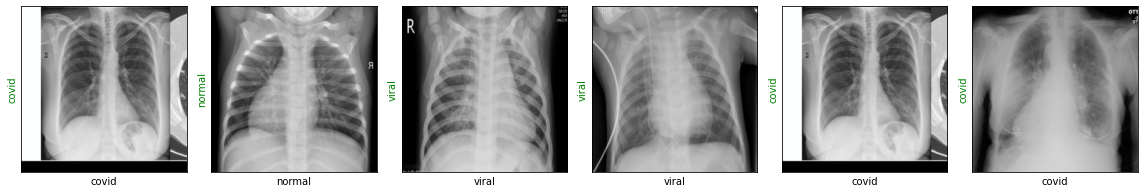

In [15]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

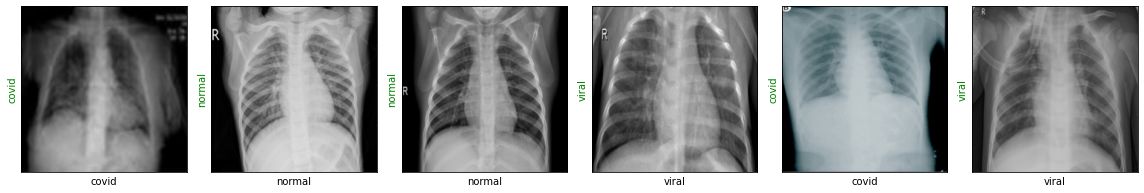

In [16]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [17]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3) 
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [19]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    
    resnet18.cpu()
    outputs  = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

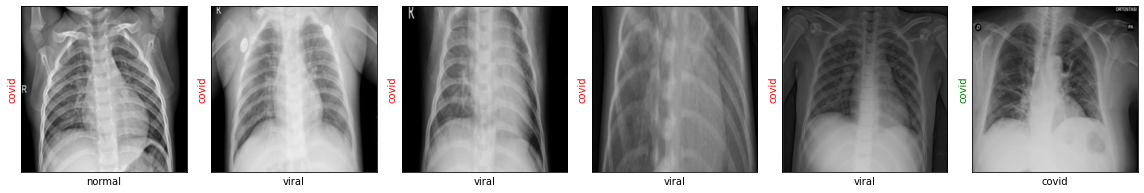

In [20]:
show_preds()

# Training the Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [41]:
def train(epochs):
    print('Starting training..')
    for epoch in range(0, epochs):
        
        #send model to device we are using
        resnet18.to(device)
        
        print('='*20)
        print(f'Starting epoch {epoch + 1}/{epochs}')
        print('='*20)
        
        progress_bar = tqdm(dl_train,
                        desc = 'Epoch {:1d}'.format(epoch),
                        leave = False,   #overwrite after each epoch
                        disable = False                        
                       )
        
        train_loss = 0.
        resnet18.train() # set model to training phase
        
        for batch in progress_bar:
            batch = tuple(b.to(device) for b in batch)
            # print(len(batch)) is 2
            images = batch[0]
            labels = batch[1]
            
            # print(type(images), "in training")
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
            
        train_loss /= (len(dl_train) + 1)
        print(f'Training Loss: {train_loss:.4f}')
        
        
        test_loss = 0.
        accuracy = 0
        resnet18.eval() # set model to eval phase

        for test_step, (images_test, labels_test) in enumerate(dl_test):
            images_test = images_test.to(device)
            labels_test = labels_test.to(device)
            
            # print(type(images_val)) prints "torch.tensor". However, it refers to something located on GPU 
            with torch.no_grad():        
                outputs_test = resnet18(images_test)
            
            loss = loss_fn(outputs_test, labels_test)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            #print("preds: ", preds)
            accuracy += sum((preds == labels).cpu().numpy())
        
        
        #print(len(dl_test))
        test_loss /= len(dl_test)
        accuracy /= len(dl_test)        
        print(f'Validation Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

        show_preds()

        resnet18.train()


        
        
        if accuracy >= 0.99:
            print('Performance condition satisfied, stopping..')
            return
                
    print('Training complete..')
         

In [42]:
   
        """    
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')
    """

"    \nfor train_step, (images, labels) in enumerate(dl_train):\n    optimizer.zero_grad()\n    outputs = resnet18(images)\n    loss = loss_fn(outputs, labels)\n    loss.backward()\n    optimizer.step()\n    train_loss += loss.item()\n    if train_step % 20 == 0:\n        print('Evaluating at step', train_step)\n\n        accuracy = 0\n\n        resnet18.eval() # set model to eval phase\n\n        for val_step, (images, labels) in enumerate(dl_test):\n            outputs = resnet18(images)\n            loss = loss_fn(outputs, labels)\n            val_loss += loss.item()\n\n            _, preds = torch.max(outputs, 1)\n            accuracy += sum((preds == labels).numpy())\n\n        val_loss /= (val_step + 1)\n        accuracy = accuracy/len(test_dataset)\n        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')\n\n        show_preds()\n\n        resnet18.train()\n\n        if accuracy >= 0.95:\n            print('Performance condition satisfied, stopping..')\n      

Starting training..
Starting epoch 1/1


Training Loss: 0.1194
Validation Loss: 0.0938, Accuracy: 1.0000


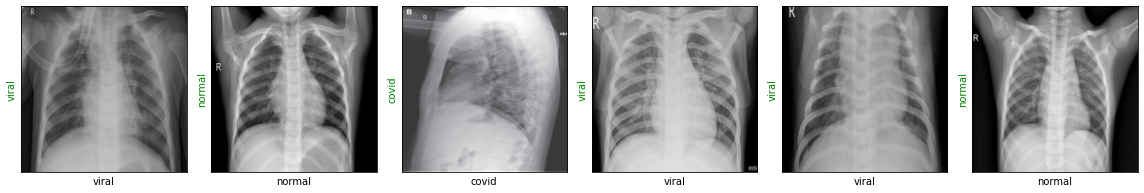

Performance condition satisfied, stopping..
Wall time: 1min 38s


In [44]:
%%time

train(epochs=1)

# Final Results

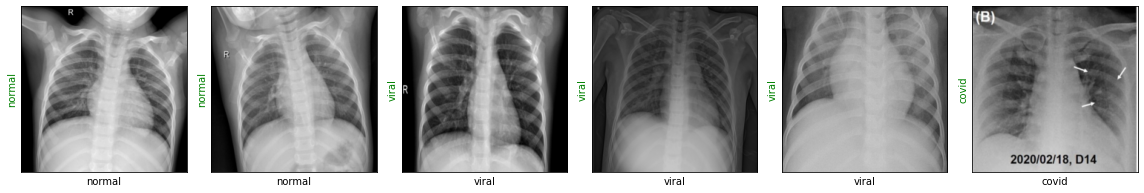

In [45]:
show_preds()